## ADVANCED LANE FINDING PROJECT
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Distortion correction using cheesbaord images
* use chessboard images to obtain image points and object points
* use the OpenCV functions cv2.calibrateCamera() and cv2.undistort() to compute the calibration and undistortion.

In [2]:
def camera_calibation():
    images = glob.glob('camera_cal/calibration*.jpg')
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0),(1,0,0), (2,0,0) .....,(7,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

    for idx, fname in enumerate(images):    
        img = cv2.imread(fname)

        # Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # draw and display the corners
            # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

            cv2.waitKey(500)

            # Camera calibration, given object points, image points, and the shapo of the grayscale image
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist 

def test_camera_calibation(mtx, dist):
    images = glob.glob('camera_cal/calibration*.jpg')
    img = cv2.imread(images[13])
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undist_img,'gray')
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return   

def display_undistorted_image(mtx, dist):
    img = cv2.imread('test_images/straight_lines1.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undist_img)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return undist_img


def display_color_gradient_threshold(result1, result2):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(result1)
    ax1.set_title('Stacked thresholds image', fontsize=40)

    ax2.imshow(result2, cmap='gray')
    ax2.set_title('Combined S channel and gradient thresholds', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return

def display_perspective_transform (img, result):
    
    img_size = (img.shape[1], img.shape[0])
    center = [img_size[0]/2, img_size[1]/2]
    offset1 = [210,200]
    offset2 = [360,300]
    offset3 = [13, 7]
    
    src = np.float32([[center[0]-offset1[0]+offset3[1], center[1]+offset1[1]], [center[0]+offset1[0]+offset3[1], center[1]+offset1[1]], 
                      [center[0]-offset2[0]+offset3[0],center[1]+offset2[1]], [center[0]+offset2[0]+offset3[0],center[1]+offset2[1]]])
    dst = np.float32([[center[0]-offset2[0]+offset3[0], center[1]+offset1[1]], [center[0]+offset2[0]+offset3[0], center[1]+offset1[1]], 
                      [center[0]-offset2[0]+offset3[0],center[1]+offset2[1]], [center[0]+offset2[0]+offset3[0],center[1]+offset2[1]]]) 

    print('src: ' ,src)
    print('dst: ',dst)
    
    

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

            
    ax1.plot(center[0], center[1],'^')
    ax1.plot(center[0]-offset1[0]+offset3[1], center[1]+offset1[1],'.')
    ax1.plot(center[0]+offset1[0]+offset3[1], center[1]+offset1[1],'.')
    ax1.plot(center[0]-offset2[0]+offset3[0], center[1]+offset2[1],'.')
    ax1.plot(center[0]+offset2[0]+offset3[0], center[1]+offset2[1],'.')
    
    ax1.imshow(img)
    ax1.set_title('original image', fontsize=40)

    
    ax2.plot(290, 680,'.')
    ax2.plot(1010, 680,'.')
    ax2.plot(290, 0,'.')
    ax2.plot(1010, 0,'.')
    
    

    ax2.imshow(result)
    ax2.set_title('perspective transform image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return


In [3]:
def camera_image_processing(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary




In [4]:
def camera_perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    center = [img_size[0]/2, img_size[1]/2]
    offset1 = [210,200]
    offset2 = [360,300]
    offset3 = [13, 7]
    
    #plt.plot(center[0], center[1],'^')
    #plt.plot(center[0]-offset1[0]+offset3[1], center[1]+offset1[1],'.')
    #plt.plot(center[0]+offset1[0]+offset3[1], center[1]+offset1[1],'.')
    #plt.plot(center[0]-offset2[0]+offset3[0], center[1]+offset2[1],'.')
    #plt.plot(center[0]+offset2[0]+offset3[0], center[1]+offset2[1],'.')
    
    src = np.float32([[center[0]-offset1[0]+offset3[1], center[1]+offset1[1]], [center[0]+offset1[0]+offset3[1], center[1]+offset1[1]], 
                      [center[0]-offset2[0]+offset3[0],center[1]+offset2[1]], [center[0]+offset2[0]+offset3[0],center[1]+offset2[1]]])
    dst = np.float32([[center[0]-offset2[0]+offset3[0], center[1]+offset1[1]], [center[0]+offset2[0]+offset3[0], center[1]+offset1[1]], 
                      [center[0]-offset2[0]+offset3[0],center[1]+offset2[1]], [center[0]+offset2[0]+offset3[0],center[1]+offset2[1]]]) 
                                   
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    inv_M = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, inv_M

In [5]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
       
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [6]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [7]:
def camera_lane_searching(binary_warped):
    # HYPERPARAMETER
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx1, lefty1, rightx1, righty1, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty1, leftx1, 2)
    right_fit = np.polyfit(righty1, rightx1, 2)

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/680 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension
    
    
    # get curvature
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    position = (left_fit_cr[2] + right_fit_cr[2])/2
    distance_from_center = (binary_warped.shape[1]*xm_per_pix)/2 - position
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    return color_warp , left_curverad, right_curverad, distance_from_center



def display_camera_lane_searching(binary_warped):
    # HYPERPARAMETER
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx1, lefty1, rightx1, righty1, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty1, leftx1, 2)
    right_fit = np.polyfit(righty1, rightx1, 2)

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the result
    f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(result)
    ax1.set_title('finding lanes', fontsize=40)
    
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    


    return 

src:  [[  437.   560.]
 [  857.   560.]
 [  293.   660.]
 [ 1013.   660.]]
dst:  [[  293.   560.]
 [ 1013.   560.]
 [  293.   660.]
 [ 1013.   660.]]


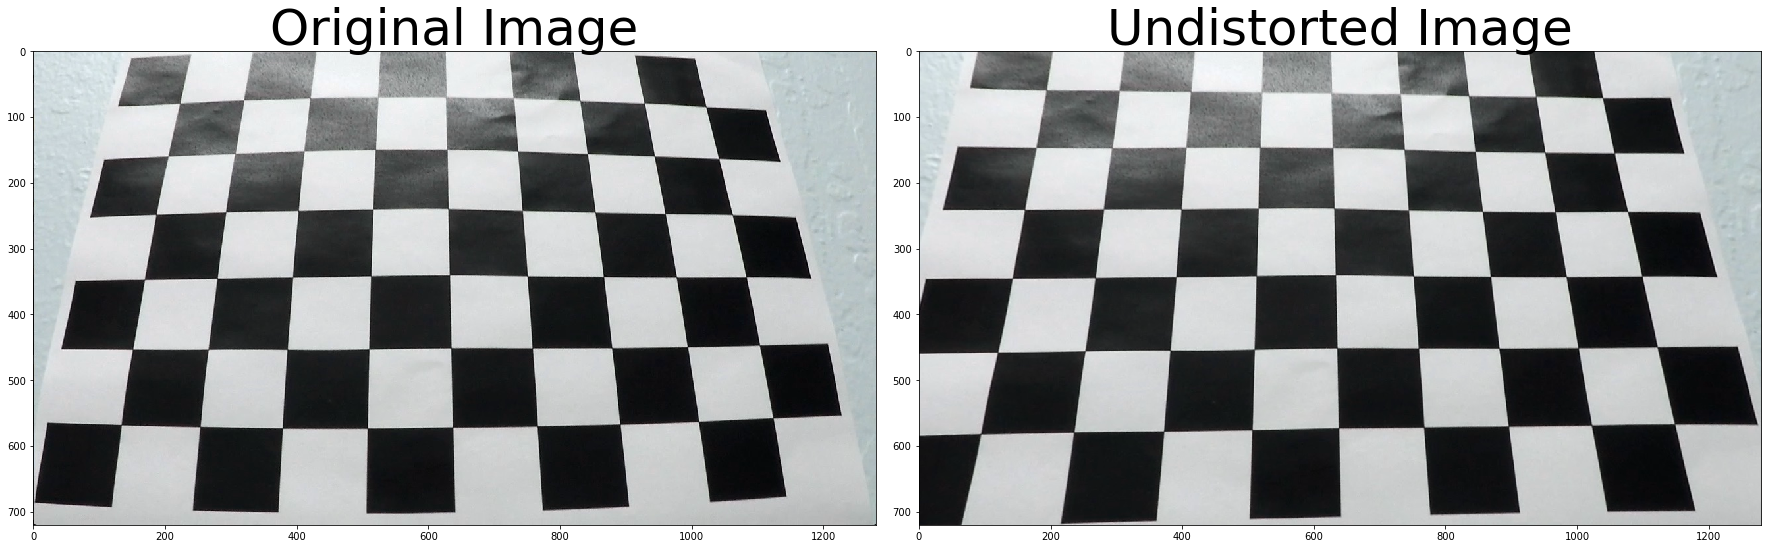

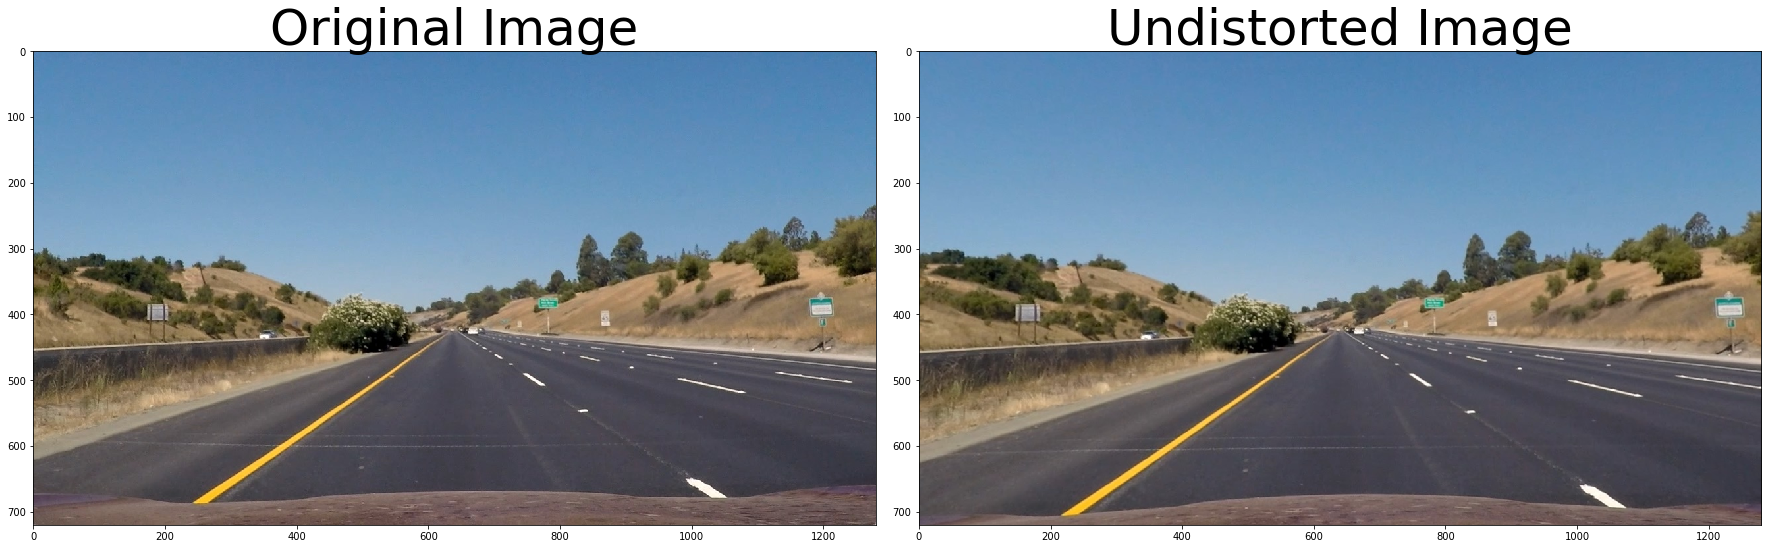

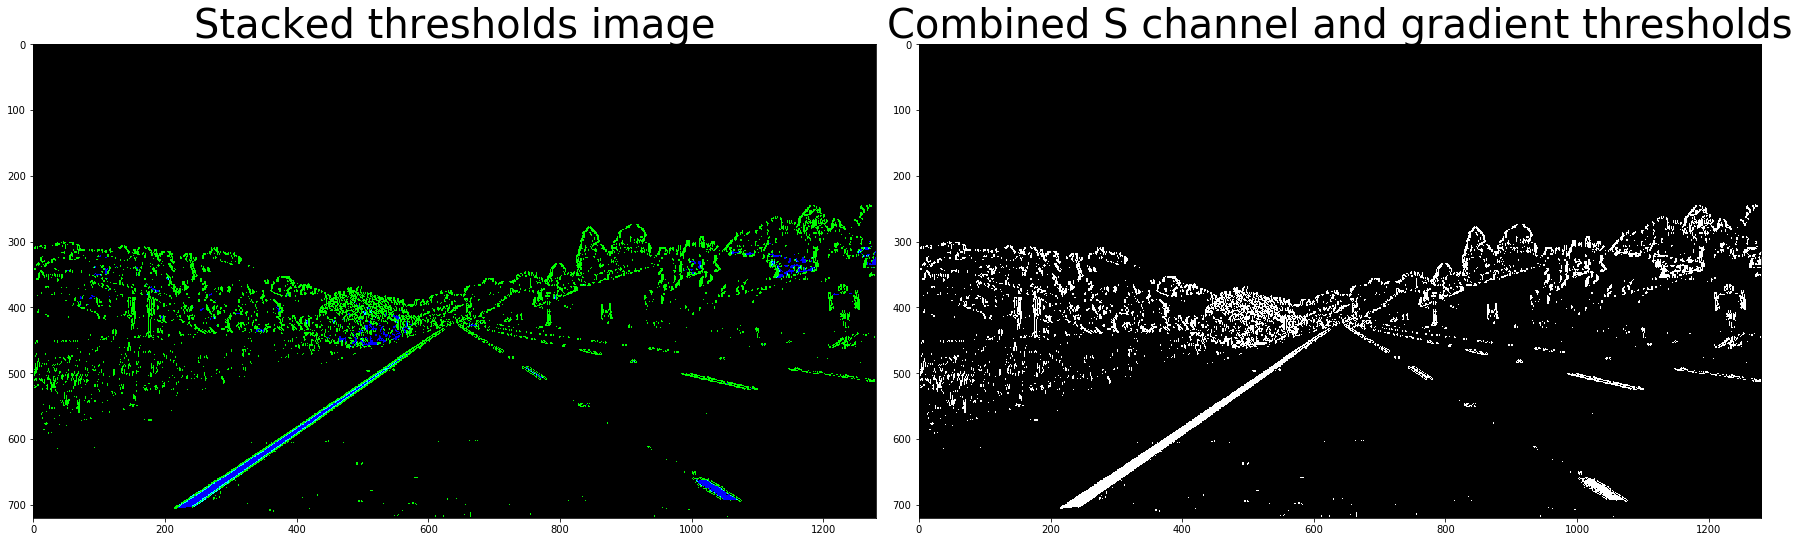

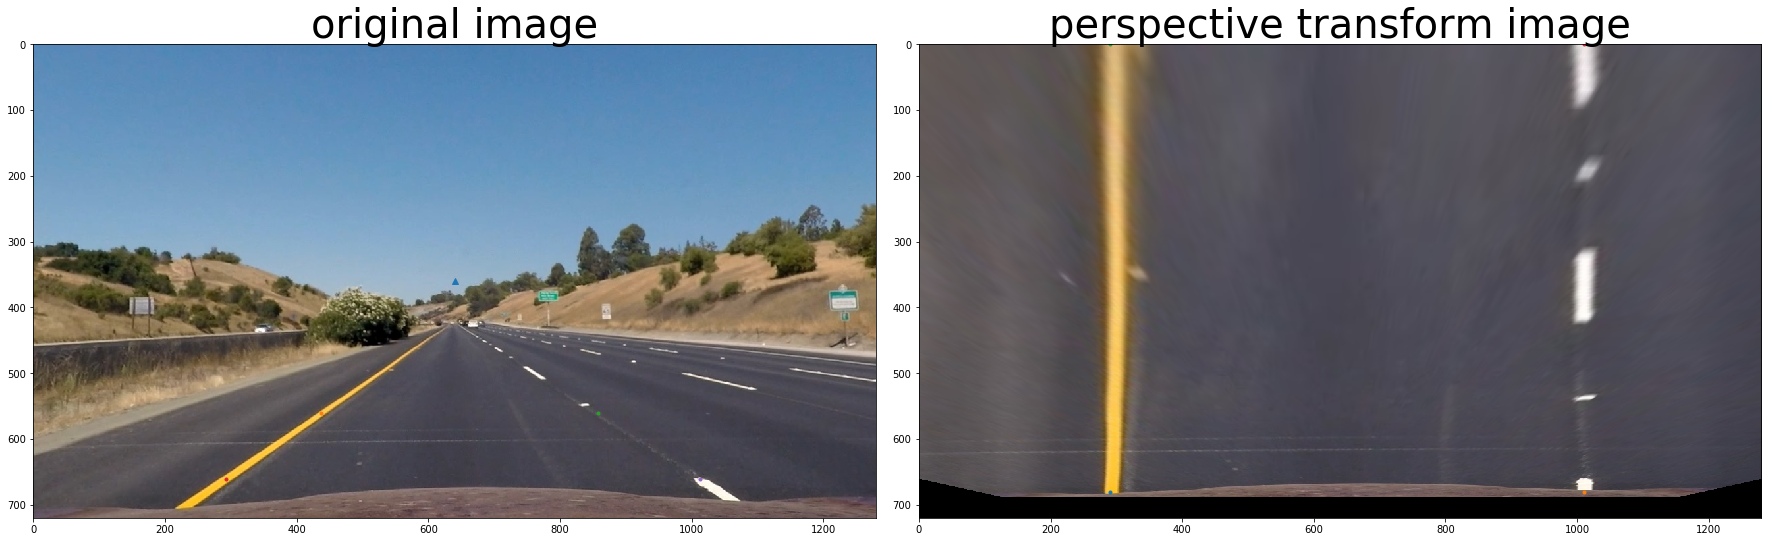

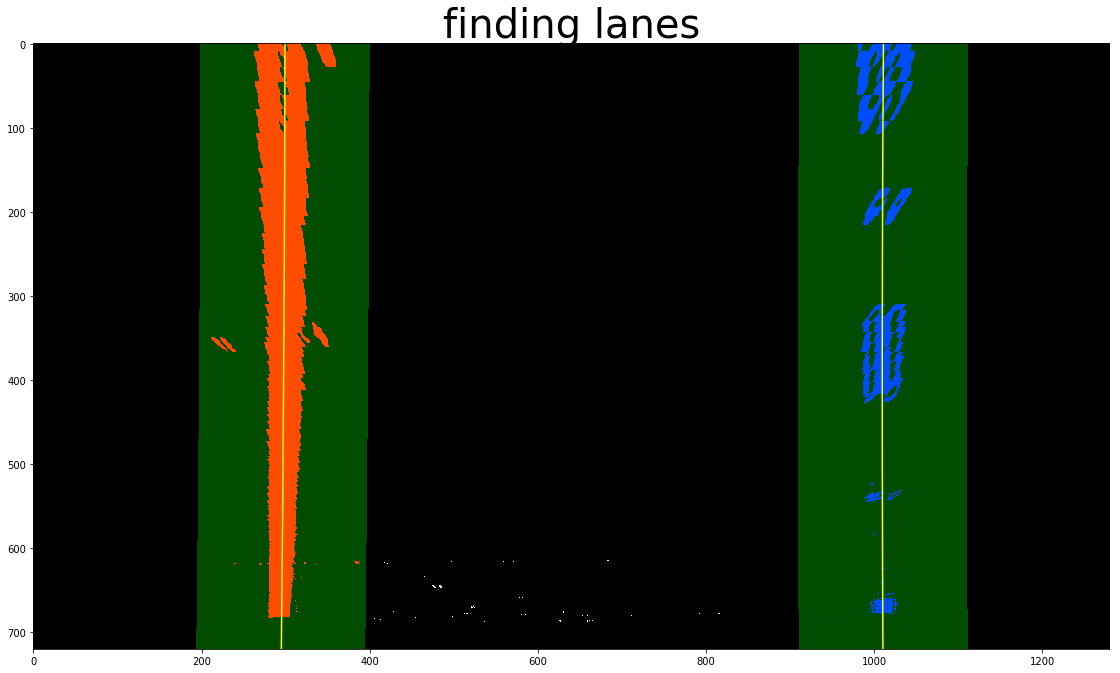

In [8]:
[mtx, dist] = camera_calibation()
## camera calibration test
test_camera_calibation(mtx, dist)
# display undistroted image
dst_img = display_undistorted_image(mtx, dist)

[result1, result2] = camera_image_processing(dst_img)
display_color_gradient_threshold(result1,result2)
[warped_img1, matrix, inv_matrix] = camera_perspective_transform(dst_img)
[warped_img2, matrix, inv_matrix] = camera_perspective_transform(result2)
display_perspective_transform(dst_img, warped_img1)
display_camera_lane_searching(warped_img2)

In [9]:
def camera_lane_detection(img):  
    #[mtx, dist] = camera_calibation()
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    [result1, result2] = camera_image_processing(dst_img)
    [warped_img, matrix, inv_matrix] = camera_perspective_transform(result2)
    [result,left_curvature, right_curvature, distance_from_center] = camera_lane_searching(warped_img)
    newwarp = cv2.warpPerspective(result, inv_matrix, (result.shape[1], result.shape[0])) 
    img = cv2.addWeighted(dst_img, 1, newwarp, 0.3, 0)
    cv2.putText(img, "Distance from center : %f [m]" % (distance_from_center), (50, 100), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1.5, (0, 0, 0))
    cv2.putText(img, "L_K: %f, R_K: %f" % (left_curvature , right_curvature), (50, 200), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1.5, (0, 0, 0))
    return img

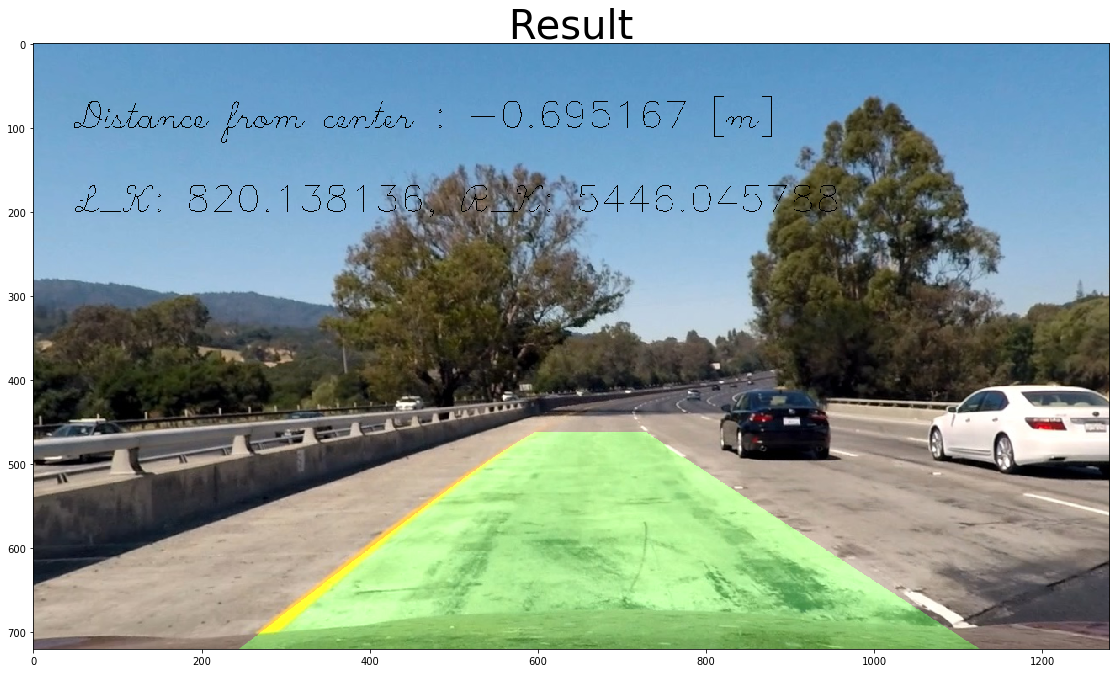

In [10]:
img = mpimg.imread('test_images/test1.jpg')
warped = camera_lane_detection(img)
f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Result', fontsize=40)

#plt.imshow(warped)

In [11]:
white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(camera_lane_detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [02:26<00:00,  8.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 6min 53s, sys: 1min 34s, total: 8min 28s
Wall time: 2min 27s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))